## NBA Shot Chart -- Season

Written by: Tim Chartier <br>
Adapted from: https://towardsdatascience.com/make-a-simple-nba-shot-chart-with-python-e5d70db45d0d


In [1]:
!pip install nba_api

from nba_api.stats.endpoints import shotchartdetail

In [2]:
# Import packages

import json
import requests
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

### Grab player ID number and team ID numbers

In [3]:
# Load teams file
teams = json.loads(requests.get('https://raw.githubusercontent.com/bttmly/nba/master/data/teams.json').text)
# Load players file
players = json.loads(requests.get('https://lifeislinear.davidson.edu/sports/player_dicts.json').text)

### ID helper functions

Create helper functions that take an input of a team name and a player’s name, and return their respective ID numbers. In both cases, if a player or team name cannot be found, the functions return -1


In [4]:
# Get team ID based on team name
def get_team_id(teamInput):
    for team in teams:
        if team['teamName'] == teamInput:
            return team['teamId']
    return -1
# Get player ID based on player name
def get_player_id(first, last):
    for player in players:
        if player['firstName'] == first and player['lastName'] == last:
            return player['playerId']
    return -1
# Get Name based on player id
def get_player_name(playerId):
    for player in players:
        if player['playerId']==playerId:
            return player['firstName'], player['lastName']
    return -1

### Collect shot data

documentation - https://github.com/swar/nba_api/blob/master/docs/nba_api/stats/endpoints/shotchartdetail.md

For made shots change to: context_measure_simple = 'PTS',
   else FGA

To get regular season data, change:             
<dd>season_type_all_star = 'Regular Season')


In [5]:
# Create JSON request
shot_json = shotchartdetail.ShotChartDetail(
            team_id = get_team_id('Los Angeles Lakers'),
            player_id = get_player_id('LeBron', 'James'),
            context_measure_simple = 'FGA',
            season_nullable = '2021-22',
            season_type_all_star = 'Regular Season')

# Load JSON data into dictionary
shot_data = json.loads(shot_json.get_json())

### Convert dictionary to a dataframe and extra shots from a game on a given date.

In [6]:
shot_df = pd.concat(
    pd.DataFrame(shot, columns=shot_data['resultSets'][0]['headers'])
    for shot in [shot_data['resultSets'][0]['rowSet']]
)

print('There are %d shots by this player.\n' % len(shot_df))
shot_df.head(20)

There are 1221 shots by this player.



,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0022100002,36,2544,LeBron James,1610612747,Los Angeles Lakers,1,9,25,...,Right Side(R),16-24 ft.,19,196,36,1,1,20211019,LAL,GSW
1,Shot Chart Detail,0022100002,60,2544,LeBron James,1610612747,Los Angeles Lakers,1,7,32,...,Left Side Center(LC),24+ ft.,25,-146,204,1,1,20211019,LAL,GSW
2,Shot Chart Detail,0022100002,82,2544,LeBron James,1610612747,Los Angeles Lakers,1,6,8,...,Right Side Center(RC),24+ ft.,26,205,169,1,1,20211019,LAL,GSW
3,Shot Chart Detail,0022100002,193,2544,LeBron James,1610612747,Los Angeles Lakers,2,11,20,...,Left Side(L),8-16 ft.,9,-87,24,1,1,20211019,LAL,GSW
4,Shot Chart Detail,0022100002,204,2544,LeBron James,1610612747,Los Angeles Lakers,2,10,24,...,Left Side(L),8-16 ft.,14,-96,110,1,1,20211019,LAL,GSW
5,Shot Chart Detail,0022100002,258,2544,LeBron James,1610612747,Los Angeles Lakers,2,7,12,...,Left Side(L),8-16 ft.,15,-110,111,1,1,20211019,LAL,GSW
6,Shot Chart Detail,0022100002,276,2544,LeBron James,1610612747,Los Angeles Lakers,2,5,55,...,Center(C),8-16 ft.,12,61,111,1,0,20211019,LAL,GSW
7,Shot Chart Detail,0022100002,342,2544,LeBron James,1610612747,Los Angeles Lakers,2,2,3,...,Left Side(L),8-16 ft.,10,-59,92,1,1,20211019,LAL,GSW
8,Shot Chart Detail,0022100002,346,2544,LeBron James,1610612747,Los Angeles Lakers,2,1,42,...,Center(C),Less Than 8 ft.,6,50,40,1,0,20211019,LAL,GSW
9,Shot Chart Detail,0022100002,356,2544,LeBron James,1610612747,Los Angeles Lakers,2,0,42,...,Center(C),Less Than 8 ft.,3,-27,15,1,0,20211019,LAL,GSW


### Pull the made and missed shots.

In relation to our shot chart in this program, we need to flip x coordinate about the x-axis.

In [7]:
shot_df.loc[:]['LOC_X'] = -shot_df.loc[:]['LOC_X']

missedShots = shot_df.loc[shot_df['SHOT_MADE_FLAG'] == 0]
madeShots = shot_df.loc[shot_df['SHOT_MADE_FLAG'] == 1]

### Create function to draw the court

In [8]:
# Function to draw basketball court
def create_court(ax, color):
    # Short corner 3PT lines
    ax.plot([-220, -220], [0, 140], linewidth=2, color=color)
    ax.plot([220, 220], [0, 140], linewidth=2, color=color)

    # 3PT Arc
    ax.add_artist(mpl.patches.Arc((0, 140), 440, 315, theta1=0, theta2=180, facecolor='none', edgecolor=color, lw=2))

    # Lane and Key
    ax.plot([-80, -80], [0, 190], linewidth=2, color=color)
    ax.plot([80, 80], [0, 190], linewidth=2, color=color)
    ax.plot([-60, -60], [0, 190], linewidth=2, color=color)
    ax.plot([60, 60], [0, 190], linewidth=2, color=color)
    ax.plot([-80, 80], [190, 190], linewidth=2, color=color)
    ax.add_artist(mpl.patches.Circle((0, 190), 60, facecolor='none', edgecolor=color, lw=2))

    # Rim
    ax.add_artist(mpl.patches.Circle((0, 60), 15, facecolor='none', edgecolor=color, lw=2))

    # Backboard
    ax.plot([-30, 30], [40, 40], linewidth=2, color=color)

    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Set axis limits
    ax.set_xlim(-250, 250)
    ax.set_ylim(0, 470)

### Create short chart

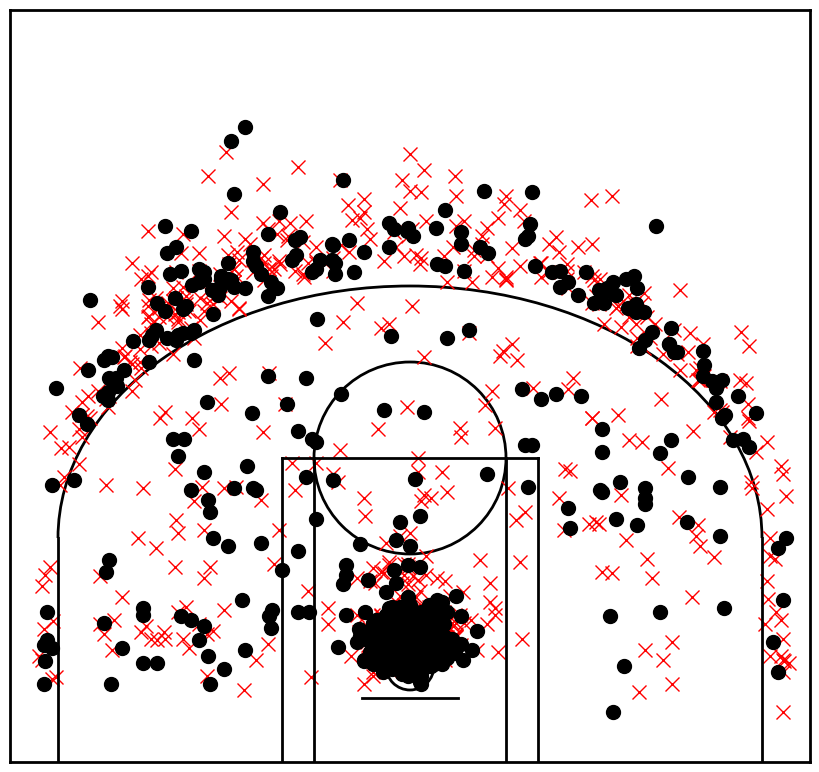

In [9]:
# General plot parameters
#mpl.rcParams['font.family'] = 'Avenir'
mpl.rcParams['font.size'] = 18
mpl.rcParams['axes.linewidth'] = 2

# Draw basketball court
#fig = plt.figure(figsize=(4, 3.76))
fig = plt.figure(figsize=(8, 7.52))
ax = fig.add_axes([0, 0, 1, 1])

# Plot shotchart
plt.plot(missedShots['LOC_X'], missedShots['LOC_Y'] + 60,'rx',markersize=10)
plt.plot(madeShots['LOC_X'], madeShots['LOC_Y'] + 60,'ko',markersize=10)

ax = create_court(ax, 'black')
# Annotate player name and season
#fig.text(0, 1.05, 'Stephen Curry\n2021-22 Playoffs Season', ha='left', va='baseline')

#plt.savefig('curryShotchartPlayoffs.png',dpi=400,pad_inches=0,bbox_inches='tight')

plt.show()

### Save the data to a CSV file for use in spreadsheets

In [ ]:
#curry_data.to_csv('curryShots.csv')

### Find the player's hot zones.

In [14]:
def shooting_perc(group):
    made = group['SHOT_MADE_FLAG'].sum()
    attempted = group['SHOT_ATTEMPTED_FLAG'].sum()
    return round((made / attempted) * 100, 2)

shot_df['ZONE_SPECIFIC'] = shot_df['SHOT_ZONE_AREA'] + ' ' + shot_df['SHOT_ZONE_RANGE']
zones = shot_df.groupby('ZONE_SPECIFIC')
shooting_zones = zones.apply(shooting_perc)

shooting_zones.head(14)

ZONE_SPECIFIC
Center(C) 16-24 ft.                30.00
Center(C) 24+ ft.                  34.51
Center(C) 8-16 ft.                 37.50
Center(C) Less Than 8 ft.          69.91
Left Side Center(LC) 16-24 ft.     50.00
Left Side Center(LC) 24+ ft.       37.78
Left Side(L) 16-24 ft.             34.78
Left Side(L) 24+ ft.               40.00
Left Side(L) 8-16 ft.              47.92
Right Side Center(RC) 16-24 ft.    48.00
Right Side Center(RC) 24+ ft.      36.13
Right Side(R) 16-24 ft.            44.44
Right Side(R) 24+ ft.              23.81
Right Side(R) 8-16 ft.             33.33
dtype: float64

### Find Heat Checks

In [15]:
def find_hh(data, player_id, hh_thresh, shot_type=-1):
    # Data - the data frame to filter
    # player_id - the player we are investigating
    # hh_thresh - how many mae shots in a row to qualify for a "hot hand"

    if shot_type == 2:
        data = data[data["SHOT_TYPE"] == "2PT Field Goal"]
    elif shot_type == 3:
        data = data[data["SHOT_TYPE"] == "3PT Field Goal"]

    
    player_data = data[data["PLAYER_ID"] == player_id]
    
    made_count = 0
    for index, row in player_data.iterrows():
        if row["SHOT_MADE_FLAG"] == 1:
            made_count += 1
        else:
            made_count = 0

        if made_count < hh_thresh:
            player_data.at[index, 'HOT_HAND'] = 0
        else:
            player_data.at[index, 'HOT_HAND'] = 1

    return player_data

def heat_check(data):
    # A function to find the misses following a hot hand
    
    # index - 1 was throwing errors, so to get the previous hot hand shots we will use shift
    temp = data
    temp['p_hh'] = data["HOT_HAND"].shift(1).fillna(0)
    data['HEAT_CHECK'] = ((data['SHOT_MADE_FLAG'] == 0) & (temp['p_hh'] == 1)).astype(int)
    
    return data

In [21]:
shot_df = find_hh(shot_df, get_player_id("LeBron", "James"), 3)
shot_df = heat_check(shot_df)

heat_check_zones = shot_df.groupby('ZONE_SPECIFIC').sum()['HEAT_CHECK']
heat_check_zones.head(14)

ZONE_SPECIFIC
Center(C) 16-24 ft.                 1
Center(C) 24+ ft.                  11
Center(C) 8-16 ft.                  2
Center(C) Less Than 8 ft.          18
Left Side Center(LC) 16-24 ft.      2
Left Side Center(LC) 24+ ft.       11
Left Side(L) 16-24 ft.              3
Left Side(L) 24+ ft.                1
Left Side(L) 8-16 ft.               4
Right Side Center(RC) 16-24 ft.     0
Right Side Center(RC) 24+ ft.      16
Right Side(R) 16-24 ft.             0
Right Side(R) 24+ ft.               2
Right Side(R) 8-16 ft.              1
Name: HEAT_CHECK, dtype: int64

In [24]:
sz = pd.DataFrame(shooting_zones)
hcz = pd.DataFrame(heat_check_zones)

analysis = pd.merge(sz, hcz, on='ZONE_SPECIFIC')
analysis.head(14)

,0,HEAT_CHECK
ZONE_SPECIFIC,,
Center(C) 16-24 ft.,30.00,1
Center(C) 24+ ft.,34.51,11
Center(C) 8-16 ft.,37.50,2
Center(C) Less Than 8 ft.,69.91,18
Left Side Center(LC) 16-24 ft.,50.00,2
Left Side Center(LC) 24+ ft.,37.78,11
Left Side(L) 16-24 ft.,34.78,3
Left Side(L) 24+ ft.,40.00,1
Left Side(L) 8-16 ft.,47.92,4
